<a href="https://colab.research.google.com/github/polortiz4/Smart-Cameras/blob/master/HW4colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/polortiz4/Smart-Cameras/blob/master/HW4/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 590 Smart Cameras 
## Fall 2019
## Homework 4
## Learning to Focus 

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import subprocess
import scipy
import skimage
import skimage.io as imio
import skimage.color as color
import skimage.transform as trans
from skimage.viewer import ImageViewer
import glob
from time import gmtime, strftime, sleep
import random
from scipy.io import loadmat
import os
import cv2
from google.colab import drive
import time
import sys

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D
from keras.engine.input_layer import Input
from keras.utils import np_utils
from keras.callbacks import TensorBoard as tensorboard
from keras import backend as K
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback


%matplotlib inline
mpl.rcParams['figure.figsize'] = (16.0, 8.0) 
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.cmap'] = 'gray'

/usr/local/lib/python3.6/dist-packages/skimage/viewer/__init__.py:6: UserWarning: Viewer requires Qt
  warn('Viewer requires Qt')
Using TensorFlow backend.


In [3]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


The file defocus.mat provides a focus model for the the tegra camera on line at nvidia@10.236.176.37. The structure of the model is discussed in the paper "Intelligent Autofocus" distributed in class. The model is a 210*4 matrix. The first column is the focus position Z_0, the second column is the defocus position Z_i, the third column is the defocus radius r for disk filter, and the fourth column is the scaling factor \alpha. (Same notations as in the paper, Section III IMAGE DEFOCUS MODEL)

The focus on this camera is adjusted using the python scripts moveFocusMotor.py and resetFocusMotor.py as in previous homework. You can see the current focus position by running the command python2 

moveFocusMotor.py sid 0

where sid is the sensor number. sid can be 1 or 2, corresponding as before to sensor 0 or 1 for the nvgstcapture command. 

In [0]:
os.chdir('/content/gdrive/My Drive/Smart-Cameras/HW4')
deFocusModel = loadmat('defocus.mat')["defocus_model"]

As shown in the plot below, the focus position scales between 1100 and 2000. The defocus position can then scale between 1100 and 2000, as shown in the orange curve, for each defocus value, there is a corresponding defocus blur diameter, as shown in the green curve at the bottom.

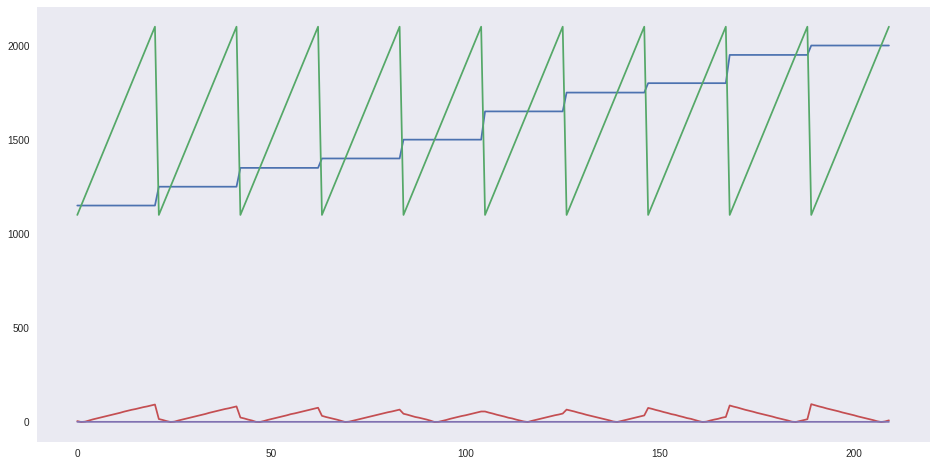

In [5]:
plt.plot(deFocusModel)

In this homework you should use the high resolution images in the libraries at 

CLIC dataset
http://www.compression.cc/challenge/

DIV2K
https://data.vision.ee.ethz.ch/cvl/DIV2K/

To generate training and test image data sets corresponding to {blurredImage, AbsoluteRangeToFocusPosition} pairs. Use the training data (with patch size 256) to train a network to estimate absolute range to focus position from an input image. Test your train network with the task of focusing the camera on online at nvidia@10.236.176.37  

The camera contains objects at various fields of view within its range, test separately on different regions of interest to evaluate your autofocus system. 

# Generate Training and Test data

In [0]:
def update_progress(progress, barLength = 100):
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rPercent: [{0}] {1}% {2}".format( "#"*block + "-"*(barLength-block), progress*100, status)
    sys.stdout.write(text)
    sys.stdout.flush()

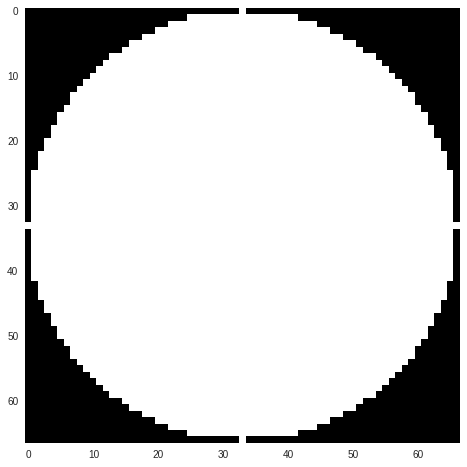

In [7]:
def kernel(r, pitch = 1):
    if r == 0:
        r = pitch
    r_length = int(r / pitch)
    x = np.arange(-r_length, r_length + 1)
    y = np.arange(-r_length, r_length + 1)
    xx, yy = np.meshgrid(x, y)
    kernel = np.zeros_like(xx)
    kernel = (xx**2 + yy**2 <= r_length**2)
    kernel = kernel / sum(sum(kernel))
    
    return kernel
kernel_example = kernel(33)
plt.imshow(kernel_example)

In [0]:
def forward_model(image, r, alpha = 1):
    if r != 0:
        image = scipy.signal.fftconvolve(image, kernel(r), mode = 'valid')
    blur_scale = cv2.resize(image, None, fx = alpha, fy = alpha)

    
    return blur_scale[:512, :512]

In [0]:
def divide_image(image, block_size = 512, alpha = 0.949, r = 95):
    preblur_size = int(block_size / min(deFocusModel[:, 3]) + 2 * max(deFocusModel[:, 2]))
    blocks = np.zeros([1, preblur_size, preblur_size])
    
    row_length = image.shape[0] - np.mod(image.shape[0], block_size) + preblur_size - block_size
    col_length = image.shape[1] - np.mod(image.shape[1], block_size) + preblur_size - block_size

    if np.mod(image.shape[0], block_size) < preblur_size - block_size:
        row_length -= block_size
    if np.mod(image.shape[1], block_size) < preblur_size - block_size:
        col_length -= block_size
    row_length = int(np.floor(row_length / block_size))
    col_length = int(np.floor(col_length / block_size))
    for row in range(row_length):
        for col in range (col_length):
            block = image[block_size*row : block_size*row + preblur_size, block_size*col : block_size*col + preblur_size]
            blocks = np.append(blocks, block[np.newaxis, :, :], axis = 0)
            
    if image.shape[0] < preblur_size or image.shape[1] < preblur_size:
#         print('too small')
        block = cv2.resize(image, (preblur_size, preblur_size))
        blocks = np.append(blocks, block[np.newaxis, :, :], axis = 0)
    
    return blocks[1:, :, :]

(384, 512)
(1, 729, 729)


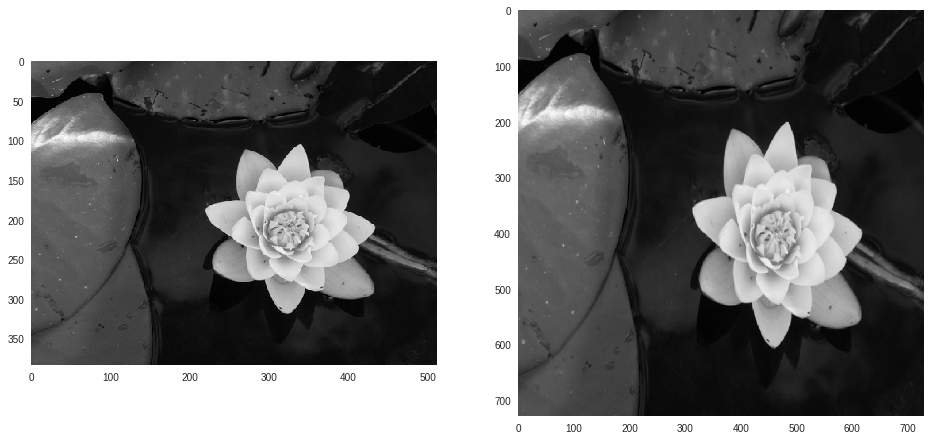

In [10]:
a = imio.imread('valid/schicka-307.png')
a = color.rgb2gray(a)
b = cv2.resize(a, (512, 512))
b = divide_image(a)
print(a.shape)

print(b.shape)
plt.subplot(1,2,1)
plt.imshow(a)
plt.subplot(1,2,2)
plt.imshow(b[0])

In [0]:
# open("train_filename.txt", "w").close()
# f_train = open("train_filename.txt", "a")
# for i, filename in  enumerate(os.listdir('train')):
#   f_train.write(filename + "\n")

In [0]:
def generate_arrays_from_file(path):
  while True:
    block_size = 512
    preblur_size = int(block_size / min(deFocusModel[:, 3]) + 2 * max(deFocusModel[:, 2]))            
    with open(path) as f:
      for line in f:
        filename = line[:-1]
#         print(filename)
        x_train = np.zeros([1, block_size, block_size])
        try:
          image = imio.imread(path[:5] + "/" + filename)
        except:
          raise TypeError("MAYBE, the length of the txt names with filenames is different")
        image = color.rgb2gray(image)
        blocks = divide_image(image)
#         print('image.shape' + str(image.shape))
#         print('blocks_size: ' + str(blocks.shape))
        y_train = np.zeros(blocks.shape[0])
        for i, block in enumerate(blocks):
            z0 = random.choice(np.unique(deFocusModel[:, 0]))
            z1 = random.choice(np.unique(deFocusModel[:, 1]))
            r = deFocusModel[np.where(np.multiply(deFocusModel[:, 1] == z1, deFocusModel[:, 0] == z0)), 2]
            alpha = deFocusModel[np.where(np.multiply(deFocusModel[:, 1] == z1, deFocusModel[:, 0] == z0)), 3]
#             print('z0: ' + str(z0))
#             print('z1: ' + str(z1))
#             print('r: ' + str(r))
#             print('alpha: ' + str(alpha))
            
            block = block[:int(np.ceil(block_size/alpha + 2*r)), :int(np.ceil(block_size/alpha + 2*r))]
            blur_block = forward_model(block, r, alpha)
#             print('image.shape' + str(image.shape))
#             print('block.shape" ' + str(block.shape))
#             print('x_train.shape" ' + str(x_train.shape))
#             print('blur_block.shape: ' +str(blur_block.shape))
            if np.any(blur_block == np.inf):
              x_train = np.append(x_train, np.zeros_like(blur_block[np.newaxis, :, :]), axis = 0)
              y_train[i] = abs(0)
              print('Infinity Error')
            elif blur_block.shape != (block_size, block_size):
              x_train = np.append(x_train, np.zeros_like(blur_block[np.newaxis, :, :]), axis = 0)
              y_train[i] = abs(0)
              print('Wrong Size')              
            else:
              x_train = np.append(x_train, blur_block[np.newaxis, :, :], axis = 0)
              y_train[i] = abs(z1 - z0)
#               print('y_train.shape: ' + str(y_train.shape))
        
      
        yield ({"conv2d_1_input": x_train[1:, :, :, np.newaxis]}, {'dense_4': y_train})

In [0]:
# open("valid_filename.txt", "w").close()
# f_train = open("valid_filename.txt", "a")
# for i, filename in  enumerate(os.listdir('valid')):
#   f_train.write(filename + "\n")

In [14]:
tbc = TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://0acab21b.ngrok.io


In [0]:
def base_model():
  
  model = Sequential()
  model.add(Conv2D(4, (8, 8), strides = 8, padding = 'same', activation = 'relu', input_shape = (512, 512, 1)))
  model.add(Conv2D(8, (4, 4), strides = 4, padding = 'same', activation = 'relu'))
  model.add(Conv2D(8, (4, 4), strides = 4, padding = 'same', activation = 'relu'))
  model.add(Flatten())
  model.add(Dense(1024, activation = 'relu'))
  model.add(Dense(512, activation = 'relu'))
  model.add(Dense(10, activation = 'relu'))
  model.add(Dense(1))
  
  model.compile(loss = 'mean_squared_error', optimizer = 'adam')
  return model
K.clear_session()
cnn_n = base_model()
cnn_n.summary()

tensorboard()
# cnn = cnn_n.fit(x_train[:, :, :, np.newaxis], y_train, batch_size = 32, epochs = 300, validation_data = (x_valid[:, :, :, np.newaxis], y_valid), shuffle = True)
cnn = cnn_n.fit_generator(generate_arrays_from_file('train_filename.txt'), 
                          steps_per_epoch = len(os.listdir('train')), 
                          epochs = 300, 
                          validation_data = generate_arrays_from_file('valid_filename.txt'), 
                          validation_steps = len(os.listdir('valid')),
                          max_queue_size = 600,
                          callbacks = [TensorBoardColabCallback(tbc)])
  

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 4)         260       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 8)         520       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 8)           1032      
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              132096    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dens

In [32]:
len(os.listdir('valid'))

102

In [42]:
a = generate_arrays_from_file("valid_filename.txt")
j = 0
for i in a:
  j += 1
  if j == 1:
      print(j)
      print(i[0]["conv2d_1_input"].shape)
  if np.any(i[0]["conv2d_1_input"] == np.inf):
    print('Infinity at: ' + str(j))
#   print(i[0]["conv2d_1_input"].shape)
#   print(j)

schicka-307.png
image.shape(384, 512)
blocks_size: (0, 729, 729)
1
(0, 512, 512, 1)
schicka-307.png
image.shape(384, 512)
blocks_size: (0, 729, 729)
schicka-307.png
image.shape(384, 512)
blocks_size: (0, 729, 729)
schicka-307.png
image.shape(384, 512)
blocks_size: (0, 729, 729)
schicka-307.png
image.shape(384, 512)
blocks_size: (0, 729, 729)
schicka-307.png
image.shape(384, 512)
blocks_size: (0, 729, 729)
schicka-307.png
image.shape(384, 512)
blocks_size: (0, 729, 729)
schicka-307.png
image.shape(384, 512)
blocks_size: (0, 729, 729)
schicka-307.png
image.shape(384, 512)
blocks_size: (0, 729, 729)
schicka-307.png
image.shape(384, 512)
blocks_size: (0, 729, 729)
schicka-307.png
image.shape(384, 512)
blocks_size: (0, 729, 729)
schicka-307.png
image.shape(384, 512)
blocks_size: (0, 729, 729)
schicka-307.png
image.shape(384, 512)
blocks_size: (0, 729, 729)
schicka-307.png
image.shape(384, 512)
blocks_size: (0, 729, 729)
schicka-307.png
image.shape(384, 512)
blocks_size: (0, 729, 729)
schick

TypeError: ignored

### First, we have to deal with the image format. For this we will divide each high resolution into blocks of lower resolution, which will then become our training and validation data.

In [171]:
block_size = 512
preblur_size = int(block_size / min(deFocusModel[:, 3]) + 2 * max(deFocusModel[:, 2]))
x_train = np.zeros([1, preblur_size, preblur_size])
num_train = 30
for i, filename in  enumerate(os.listdir('train')[:num_train]):
  image = imio.imread('train/' + filename) # Read image
  image = color.rgb2gray(image)
  x_train = np.append(x_train, divide_image(image), axis = 0)
  update_progress((i + 1) / num_train / 2)
x_valid = np.zeros([1, preblur_size, preblur_size])
num_valid = 30
for i, filename in  enumerate(os.listdir('valid')[:num_valid]):
  image = imio.imread('valid/' + filename) # Read image
  image = color.rgb2gray(image)
  x_valid = np.append(x_train, divide_image(image), axis = 0)
  update_progress((i + 1) / num_valid / 2 + 0.5)

Percent: [####################################################################################################] 100% Done...


### Then, we proceed to pre-process the new training data set by bulrring it and storing the off focus distance

In [172]:
y_train = np.zeros(x_train.shape[0])
y_valid = np.zeros(x_valid.shape[0])

for i, image in enumerate(x_train):
    z0 = random.choice(np.unique(deFocusModel[:, 0]))
    z1 = random.choice(np.unique(deFocusModel[:, 1]))
    r = deFocusModel[np.where(np.multiply(deFocusModel[:, 1] == z1, deFocusModel[:, 0] == z0)), 2]
    alpha = deFocusModel[np.where(np.multiply(deFocusModel[:, 1] == z1, deFocusModel[:, 0] == z0)), 3]
    x_train[i, :block_size, :block_size] = pre_process(image, r = r, alpha = alpha)
    y_train[i] = abs(z1 - z0)
    update_progress(i / x_train.shape[0])
    
for i, image in enumerate(x_valid):
    z0 = random.choice(np.unique(deFocusModel[:, 0]))
    z1 = random.choice(np.unique(deFocusModel[:, 1]))
    r = deFocusModel[np.where(np.multiply(deFocusModel[:, 1] == z1, deFocusModel[:, 0] == z0)), 2]
    alpha = deFocusModel[np.where(np.multiply(deFocusModel[:, 1] == z1, deFocusModel[:, 0] == z0)), 3]
    x_valid[i, :block_size, :block_size] = pre_process(image, r = r, alpha = alpha)
    y_valid[i] = abs(z1 - z0)
    update_progress(i / x_valid.shape[0])
x_train = x_train[:, :512, :512]
x_valid = x_valid[:, :512, :512]

Percent: [###################################################################################################-] 99.34640522875817% 

In [176]:
y_train.shape

(147,)

In [26]:
num_train = len(os.listdir('train'))
num_train = 1
print('num_train: ' + str(num_train))
x_train = np.zeros([num_train, 512, 512])
y_train = np.zeros(num_train)
for i, filename in  enumerate(os.listdir('train')[:num_train]):
    print('i: ' + str(i))
    z0 = random.choice(np.unique(deFocusModel[:, 0]))
    z1 = random.choice(np.unique(deFocusModel[:, 1]))
    r = deFocusModel[np.where(np.multiply(deFocusModel[:, 1] == z1, deFocusModel[:, 0] == z0)), 2]
    alpha = deFocusModel[np.where(np.multiply(deFocusModel[:, 1] == z1, deFocusModel[:, 0] == z0)), 3]
    block = pre_process(filename, folder = 'train/', r = r, alpha = alpha)
    
    if block.shape == (512, 512):
        x_train[i, :, :] = block
        y_train[i] = abs(z1 - z0)
    else:
        x_train[i, :, :] = x_train[i-1, :, :]
        y_train[i] = y_train[i-1]
        print('error')

num_train: 1
i: 0


TypeError: ignored

In [21]:
num_valid = len(os.listdir('valid'))
num_valid = 1
print('num_valid: ' + str(num_valid))
x_valid = np.zeros([num_valid, 512, 512])
y_valid = np.zeros(num_valid)
for i, filename in  enumerate(os.listdir('valid')[:num_valid]):
    print('i: ' + str(i))
    z0 = random.choice(np.unique(deFocusModel[:, 0]))
    z1 = random.choice(np.unique(deFocusModel[:, 1]))
    r = deFocusModel[np.where(np.multiply(deFocusModel[:, 1] == z1, deFocusModel[:, 0] == z0)), 2]
    alpha = deFocusModel[np.where(np.multiply(deFocusModel[:, 1] == z1, deFocusModel[:, 0] == z0)), 3]
    block = pre_process(filename, folder = 'valid/', r = r, alpha = alpha)
    
    if block.shape == (512, 512):
        x_valid[i, :, :] = block
        y_valid[i] = abs(z1 - z0)
    else:
        x_valid[i, :, :] = x_valid[i-1, :, :]
        y_valid[i] = y_valid[i-1]
        print('error')

num_valid: 1
i: 0


NameError: ignored

In [0]:
x_train[:, :, :, np.newaxis].shape

(1633, 512, 512, 1)

In [65]:
len(os.listdir('valid'))

102

In [0]:
np.save('train_data', x_train)
np.save('train_label', y_train)
np.save('valid_label', y_valid)
np.save('valid_data', x_valid)

In [0]:
cnn_n.save('trained_weights.h5')
cnn_n.save_weights('trained_weights.h5')

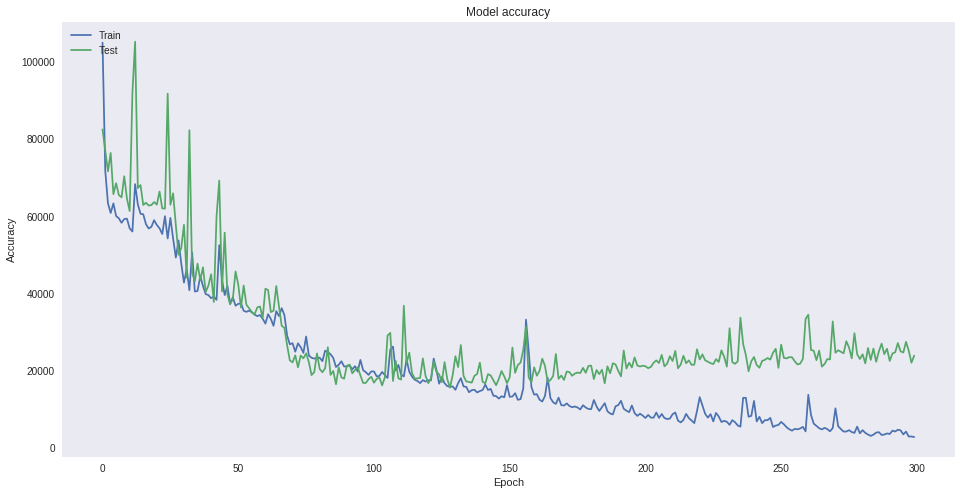

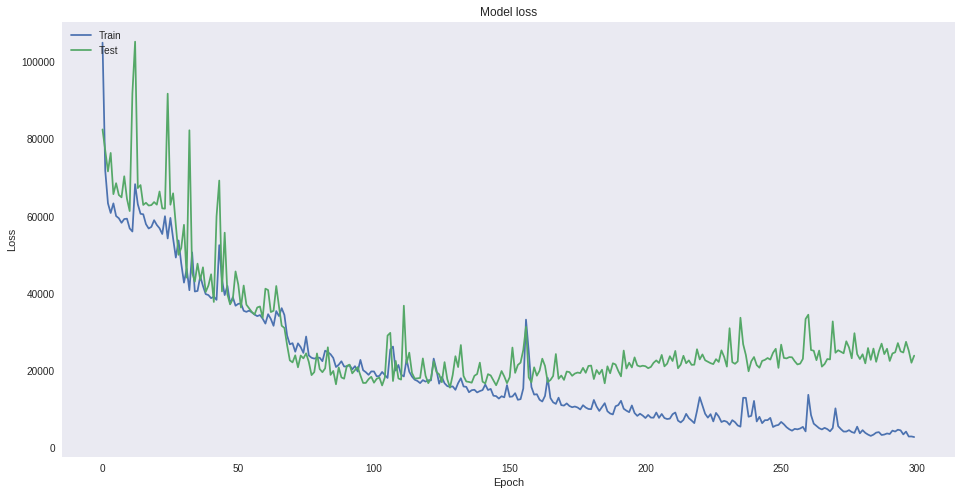

In [0]:
# Plot training & validation accuracy values
plt.plot(cnn.history['loss'])
plt.plot(cnn.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

# Plot training & validation loss values
plt.plot(cnn.history['loss'])
plt.plot(cnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

In [0]:
d = 19
print(y_valid[d])
print(cnn_n.predict(x_valid[d:d+1, :, :, np.newaxis]))

900.0
[[739.50183]]
